In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.utils as vutils
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import math
import random
import sys
import os
import os.path
import torchvision.datasets as torchdata
from torch.utils.data import Subset
import warnings
sys.path.append('./dci_code')
from dci import DCI
import collections
import argparse
from tqdm import tqdm
from sklearn.preprocessing import normalize
import pickle
from collections import deque
import signal
from torchviz import make_dot
try:
    from itertools import izip as zip
except ImportError: # Python 3
    pass

%matplotlib inline

from models import vgg19_bn

In [3]:
# import PyQt5
# %matplotlib qt
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [ ]:
def sample_points_on_sphere(anchor, angle, num_points):
    # Normalize the vector with which we want the points to make a certain angle to have unit length
    x = vector / np.linalg.norm(vector)
    # Generate a random vector of the same dimensions as the sphere
    v = np.random.randn(*vector.shape, num_points)
    # Project v onto the orthogonal complement of the vector x
    y = v - np.dot(np.transpose(v), x) * x
    # Normalize the resulting vector to have unit length
    y = y / np.linalg.norm(y, axis=0)
    # Compute the unit vector perpendicular to both x and y
    z = np.cross(x, y, axis=0)
    # Generate n uniformly distributed points on a circle of radius sin(θ) in the plane spanned by x and z
    t = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    r = np.sin(angle)
    circle_points = np.stack([r * np.cos(t), r * np.sin(t), np.zeros(num_points)])
    # Compute the corresponding points on the sphere by using Rodrigues' rotation formula
    a = np.cos(angle)
    b = np.sin(angle) * x
    c = np.cross(z, circle_points, axis=0)
    rotated_points = a * circle_points + b + c
    # Add a small random perturbation to each point
    noise = np.random.randn(*vector.shape, num_points)
    return rotated_points + noise

In [11]:
def find_scaling_factor_angular(encodings,learning_nn=10):
    encodings = test_img_embeds.astype(np.float64)
    encodings = encodings / np.expand_dims(np.linalg.norm(encodings,axis=1),-1)
    dci_db = DCI(encodings.shape[1], num_comp_indices = 2, num_simp_indices = 7)
    dci_db.reset()
    dci_db.add(encodings, num_levels = 2, field_of_view = 10, prop_to_retrieve = 0.25)
    nearest_indices, nearest_dists = dci_db.query(encodings, num_neighbours = learning_nn, field_of_view = 10, prop_to_retrieve = 0.25)
    n_nearest_indices = np.array(nearest_indices)[:,learning_nn-1]
    n_nn = encodings[n_nearest_indices]
    n_nn = n_nn / np.expand_dims(np.linalg.norm(n_nn,axis=1),-1)
    scaling_factor = np.arccos(np.clip(np.einsum('ij,ij->i',n_nn,encodings),-1,1))
    return scaling_factor

In [12]:
encoder_model = vgg19_bn()
encoder_model = torch.load("./encoder_classifier.pth")
encoder_model.eval() # for evaluation

if torch.cuda.is_available():
    encoder_model.cuda()

In [13]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        img_list.extend(imgs.cpu().detach().numpy())
        with torch.no_grad():
            z = model(imgs.cuda()).cpu().detach().numpy()
        embed_list.extend(z)
    return (np.array(img_list),np.array(embed_list))

In [14]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchdata.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainset = torchdata.CIFAR10(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(testset, 
    batch_size=256, 
    shuffle=True, 
    drop_last=False, 
    pin_memory=True, 
    num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
test_imgs, test_img_embeds = embed_imgs(encoder_model, data_loader)

In [16]:
s = find_scaling_factor_angular(test_img_embeds,learning_nn=1)

In [17]:
s

array([0.00000000e+00, 1.49011612e-08, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [18]:
# encodings = test_img_embeds.astype(np.float64)
# learning_nn = 1
# encodings = encodings / np.expand_dims(np.linalg.norm(encodings,axis=1),-1)
# dci_db = DCI(encodings.shape[1], num_comp_indices = 2, num_simp_indices = 7)
# dci_db.reset()
# dci_db.add(encodings, num_levels = 2, field_of_view = 10, prop_to_retrieve = 0.25)
# nearest_indices, nearest_dists = dci_db.query(encodings, num_neighbours = learning_nn, field_of_view = 10, prop_to_retrieve = 0.25)
# n_nearest_indices = np.array(nearest_indices)[:,learning_nn-1]
# n_nn = encodings[n_nearest_indices]
# n_nn = n_nn / np.expand_dims(np.linalg.norm(n_nn,axis=1),-1)
# scaling_factor = np.clip(np.einsum('ij,ij->i',n_nn,encodings),-1,1)
    

In [19]:
encodings = test_img_embeds.astype(np.float64)
learning_nn = 10
encodings = encodings / np.expand_dims(np.linalg.norm(encodings,axis=1),-1)
dci_db = DCI(encodings.shape[1], num_comp_indices = 2, num_simp_indices = 7)
dci_db.reset()
dci_db.add(encodings, num_levels = 2, field_of_view = 10, prop_to_retrieve = 0.25)
nearest_indices, nearest_dists = dci_db.query(encodings, num_neighbours = learning_nn, field_of_view = 10, prop_to_retrieve = 0.25)

In [20]:
n_nearest_indices = np.array(nearest_indices)[:,learning_nn-1]
n_nn = encodings[n_nearest_indices]
n_nn = n_nn / np.expand_dims(np.linalg.norm(n_nn,axis=1),-1)
scaling_factor = np.arccos(np.einsum('ij,ij->i',n_nn,encodings))

In [21]:
s

array([0.00000000e+00, 1.49011612e-08, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [22]:
test_imgs=test_imgs.astype(np.float64)
test_img_embeds=test_img_embeds.astype(np.float64)

In [23]:
dci_db = DCI(test_img_embeds.shape[1], num_comp_indices = 2, num_simp_indices = 7)
dci_db.reset()
dci_db.add(test_img_embeds, num_levels = 2, field_of_view = 10, prop_to_retrieve = 0.25)

In [24]:
nearest_indices, nearest_dists = dci_db.query(test_img_embeds, num_neighbours = 150, field_of_view = 10, prop_to_retrieve = 0.25)

In [25]:
nearest_indices_15 = np.array(nearest_indices)[:,1]
nearest_dists_15 = np.array(nearest_dists)[:,1]

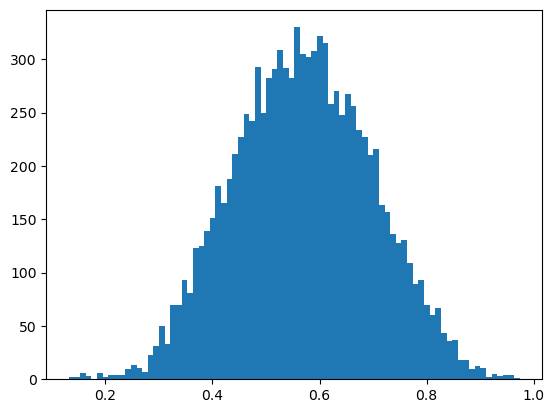

In [26]:
plt.hist(nearest_dists_15,bins=80)
plt.show()

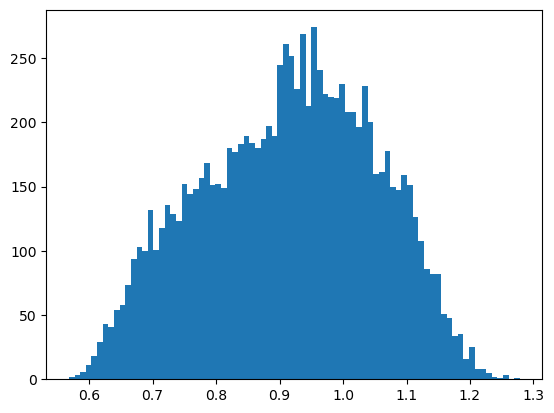

In [27]:
nearest_indices_150 = np.array(nearest_indices)[:,149]
nearest_dists_150 = np.array(nearest_dists)[:,149]
plt.hist(nearest_dists_150,bins=80)
plt.show()

In [28]:
f = []
h = []
for i in range(len(test_img_embeds)):
    nn_150 = test_img_embeds[nearest_indices_150[i]]
    nn_15 = test_img_embeds[nearest_indices_15[i]]

    f.append((np.arccos(np.dot(test_img_embeds[i],nn_150))))
    h.append((np.arccos(np.dot(test_img_embeds[i],nn_15))))


    

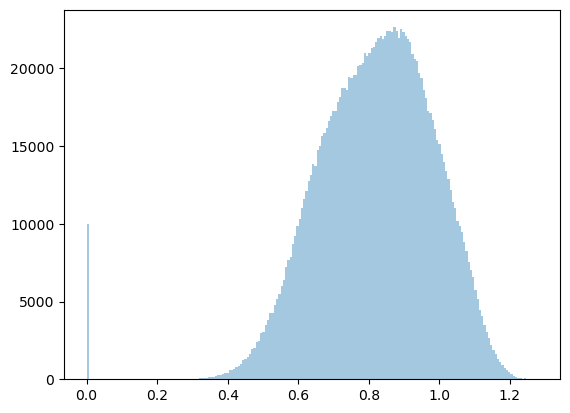

In [29]:
flat = np.array(nearest_dists).flatten()
plt.hist(flat,200,alpha=0.4)
plt.show()

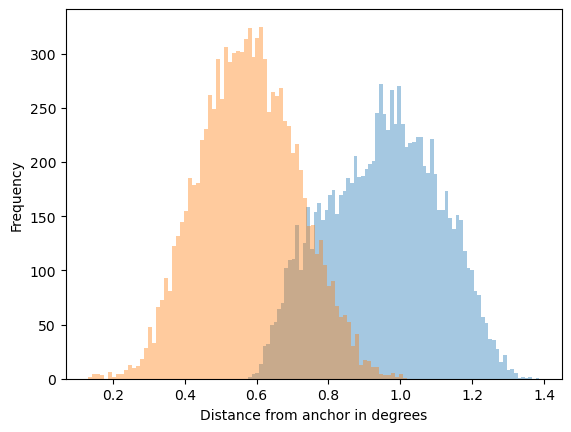

In [30]:
plt.hist(f,80,alpha=0.4)
plt.hist(h,80,alpha=0.4)
plt.xlabel("Distance from anchor in degrees")
plt.ylabel("Frequency")
plt.show()

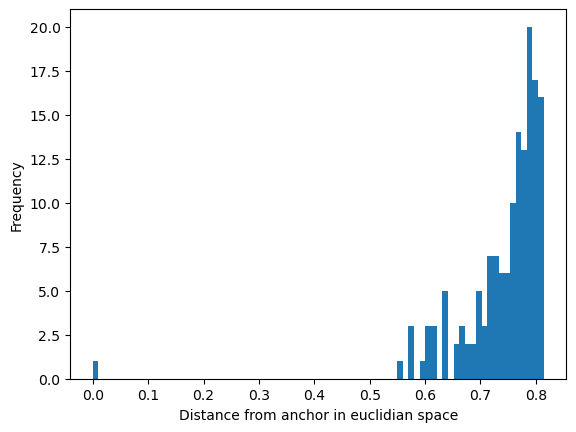

In [31]:
plt.hist(nearest_dists[0],80)
plt.xlabel("Distance from anchor in euclidian space")
plt.ylabel("Frequency")
plt.show()

## Initialize original anchor (a)

In [5]:
a = np.random.normal(0,1,(1,256))
a /= np.linalg.norm(a)

## Noise from uniform. Not normalizing the noisy samples

In [6]:
b = np.random.uniform(0,10,(10000,256))
b = b / np.expand_dims(np.linalg.norm(b,axis=1),-1)
c = np.random.uniform(0,2.5,(10000,1))

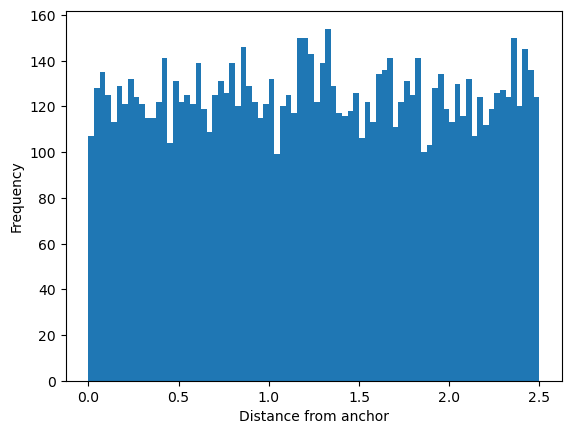

In [34]:
z = a + b*c
# norms = np.expand_dims(np.linalg.norm(z,axis=1),-1)
# z /= norms
diff = z-a
dist = np.linalg.norm(diff,axis=1)
plt.hist(dist,80)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.show()

## Noise from uniform. Normalizing the noisy samples

In [35]:
b = np.random.uniform(0,1,(10000,256))
b = b / np.expand_dims(np.linalg.norm(b,axis=1),-1)
c = np.random.uniform(0,1.4,(10000,1))

In [36]:
z = a + b*c
norms = np.expand_dims(np.linalg.norm(z,axis=1),-1)
z /= norms

In [151]:
diff = z-a
dist = np.linalg.norm(diff,axis=1)
plt.hist(dist,80)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.show()

In [38]:
angles = []
for i in range(10000):
    z_norm = z[i]/np.linalg.norm(z[i])
    angles.append(np.rad2deg(np.arccos(np.dot(a,z_norm))))

angles = np.array(angles)

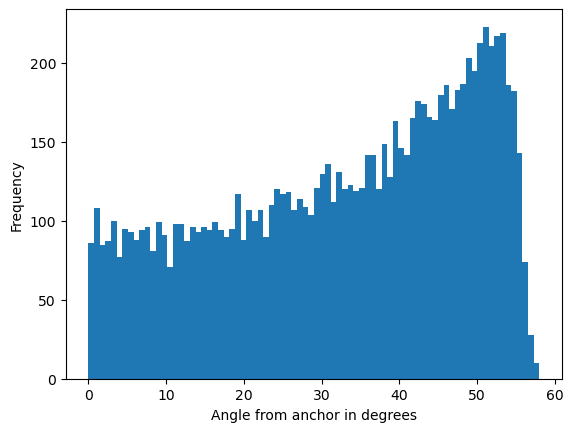

In [39]:
plt.hist(angles,80)
plt.xlabel("Angle from anchor in degrees")
plt.ylabel("Frequency")
plt.show()

## Noise from normal. Not normalizing the noisy samples

In [10]:
num_of_samples = 10000
dim = 256
a = np.random.normal(0,1,(1,dim))
a /= np.linalg.norm(a)

In [22]:
b = np.random.normal(0,1,(num_of_samples,dim))
b = b / np.expand_dims(np.linalg.norm(b,axis=1),-1)
c = np.random.uniform(0,0.8,(num_of_samples,1))

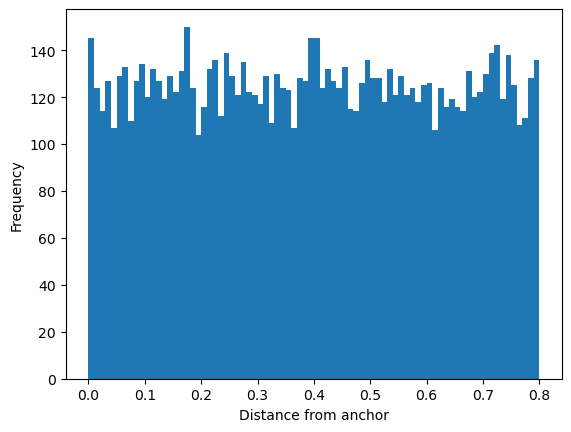

In [25]:
z = a + b*c
# norms = np.expand_dims(np.linalg.norm(z,axis=1),-1)
# z /= norms
diff = z-a
dist = np.linalg.norm(diff,axis=1)
plt.hist(dist,80)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.show()

In [19]:
random_a = np.random.normal(0,1,(5,dim))
random_a = random_a / np.expand_dims(np.linalg.norm(random_a,axis=1),-1)

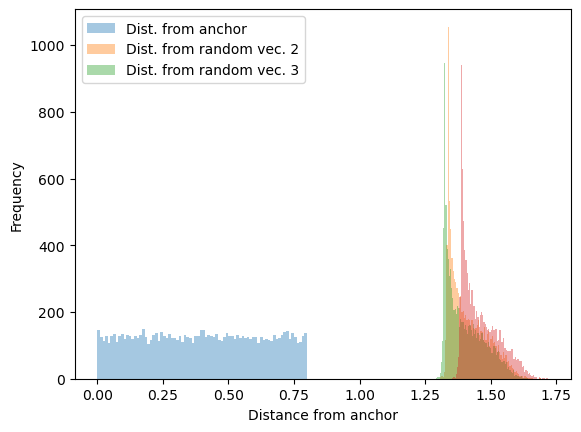

In [26]:
%matplotlib inline
dist1 = np.linalg.norm(z-random_a[0],axis=1)
dist2 = np.linalg.norm(z-random_a[1],axis=1)
dist3 = np.linalg.norm(z-random_a[2],axis=1)
dist4 = np.linalg.norm(z-random_a[3],axis=1)
plt.hist(dist,80,alpha=0.4,label="Dist. from anchor")
#plt.hist(dist1,80,alpha=0.4,label="Dist. from random vec. 1")
plt.hist(dist2,80,alpha=0.4,label="Dist. from random vec. 2")
plt.hist(dist3,80,alpha=0.4,label="Dist. from random vec. 3")
plt.hist(dist4,80,alpha=0.4)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Yolo

In [13]:
d = 0.5
p = 0.4
mean = p+(d-p)/2
std = (d - mean)
b = np.random.normal(0,1,(10000,256))
b = b / np.expand_dims(np.linalg.norm(b,axis=1),-1)
print(mean,std)
std = np.maximum(std,0.1)
std *=1
c = np.random.normal(mean,std,(10000,1))
#c = c / np.expand_dims(np.linalg.norm(c,axis=1),-1)
# print(mean,std)


0.45 0.04999999999999999


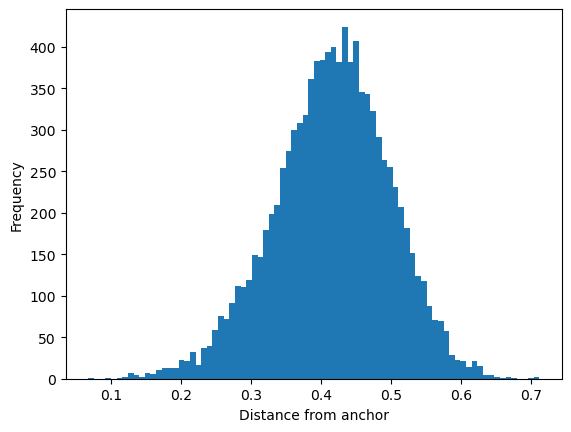

In [14]:
z = a + b*c
norms = np.expand_dims(np.linalg.norm(z,axis=1),-1)
z /= norms
diff = z-a
dist = np.linalg.norm(diff,axis=1)
plt.hist(dist,80)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.show()

In [3]:
def generate_angle(num_of_samples,curve,angle_low=0,angle_high=np.pi):
#     u_low = np.maximum(0,np.polyval(curve,angle_low))
#     u_high = np.minimum(1,np.polyval(curve,angle_high))

    # u = np.random.uniform(u_low, u_high, size=(num_of_samples))  # generate a random value between 0 and 1
    u = np.random.uniform(0, 1, size=(num_of_samples))
    theta = np.polyval(curve,u)  # calculate the angle using the inverse of the cumulative distribution function
    return theta

In [11]:
cum = []
y = 0
x = []
for i in np.arange(0, 180.0, 0.001):
    y += (np.sin(np.deg2rad(i)))**2
    x.append(np.deg2rad(i))
    cum.append(y)
cum /= y
    
curve = np.polyfit(x, cum, 5)
curve_inverse = np.polyfit(cum, x, 5)

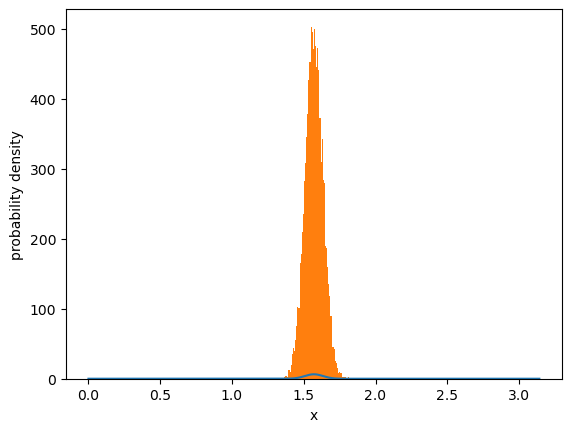

In [15]:
%matplotlib inline

x = np.linspace(0,np.pi,1000)
fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.plot(x,f(x)/np.sum(f(x)*(x[1]-x[0])) )
ax.hist(return_samples(10000),bins='auto',range=(x.min(),x.max()))
plt.show()

## Angular noise

In [2]:
from scipy import interpolate

class Angle_Generator:
    def __init__(self, dim):
        self.dim = dim

    def f(self, x):
        # does not need to be normalized
        return np.sin(x)** (self.dim - 2)

    def sample(self, g):
        x = np.linspace(0,np.pi,10000)
        y = g(x)                        # probability density function, pdf
        cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
        cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
        inverse_cdf = interpolate.interp1d(cdf_y,x) # this is a function
        curve = interpolate.interp1d(x,cdf_y) 
        return curve, inverse_cdf

    def return_samples(self, N=1000, angle_low = 0, angle_high = np.pi):
        # let's generate some samples according to the chosen pdf, f(x)
        curve, inverse_cdf = self.sample(self.f)
        u_low = curve(angle_low)
        u_high = curve(angle_high)
        uniform_samples = np.random.uniform(u_low, u_high,int(N))
        required_samples = inverse_cdf(uniform_samples)
        return required_samples

In [9]:
angle_low = np.deg2rad(0)
angle_high = np.deg2rad(180)
dim = 8
num_of_samples = 10000

a = np.random.normal(0,1,(1,dim))
a /= np.linalg.norm(a)

angle_generator = Angle_Generator(dim)

In [10]:
#angles = np.expand_dims(generate_angle(num_of_samples,curve_inverse,angle_low,angle_high),-1)
angles = np.expand_dims(angle_generator.return_samples(10000, angle_low, angle_high),-1)
# angles = np.random.uniform(angle_low,angle_high,(num_of_samples,1))

#angles = np.sin(angles)
#angles = np.random.normal(angle_low,10,(10000,1))

b = np.random.normal(0,1,(num_of_samples,dim))
b = b / np.expand_dims(np.linalg.norm(b,axis=1),-1)
w = b - np.einsum('ij,kj->ik',b,a) * a
# # Normalize w to have unit length
w = w / np.expand_dims(np.linalg.norm(w,axis=1),-1)
z = np.cos(angles) * a + np.sin(angles) * w

In [11]:
angle_generator.return_samples(10000)

array([1.39662277, 1.35665632, 1.22570001, ..., 1.90174438, 1.06781646,
       1.72147483])

In [12]:
f = np.sort(angles,axis=0)


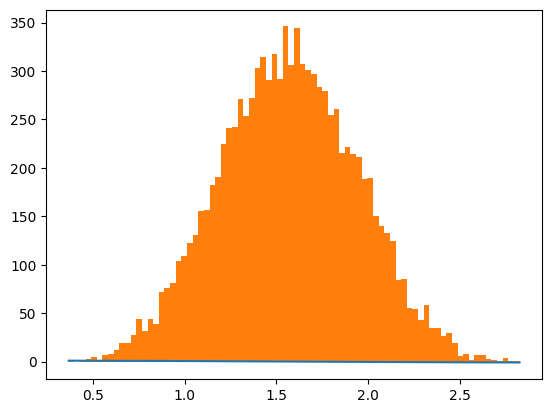

In [13]:
%matplotlib inline
plt.plot(f,np.cos(f))
plt.hist(f,bins=80)
plt.show()

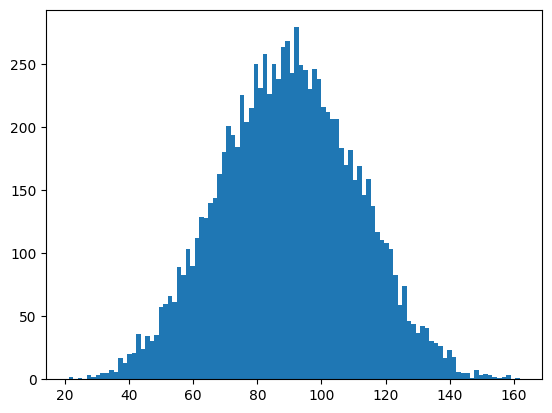

In [14]:
%matplotlib inline
plt.hist(np.rad2deg(angles),bins=100)
plt.show()

In [23]:
norms = np.expand_dims(np.linalg.norm(z,axis=1),-1)
z /= norms

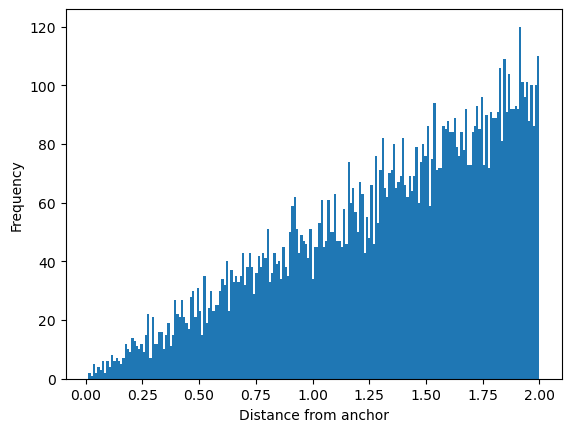

In [24]:
%matplotlib inline

diff = z-a
dist = np.linalg.norm(diff,axis=1)
plt.hist(dist,200)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.show()

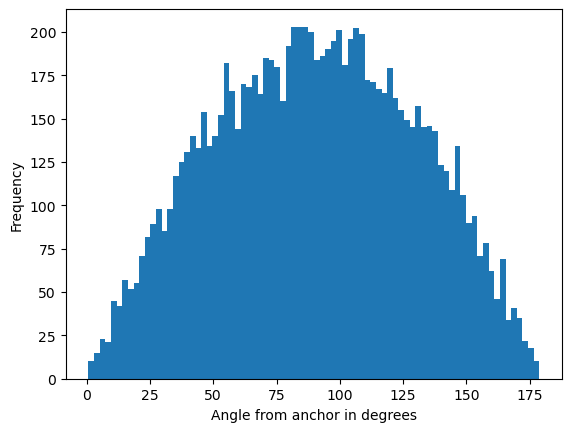

In [25]:
%matplotlib inline
angles_output = []
for i in range(10000):
    z_norm = z[i]/np.linalg.norm(z[i])
    angles_output.append(np.rad2deg(np.arccos(np.dot(a,z_norm))))

angles_output = np.array(angles_output)
plt.hist(angles_output,80)
plt.xlabel("Angle from anchor in degrees")
plt.ylabel("Frequency")
plt.show()

In [26]:
random_a = np.random.normal(0,1,(5,dim))
random_a = random_a / np.expand_dims(np.linalg.norm(random_a,axis=1),-1)

In [27]:
%matplotlib qt
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x1 = np.cos(u)*np.sin(v)
y1 = np.sin(u)*np.sin(v)
z1 = np.cos(v)
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter3D(w[:,0], w[:,1], w[:,2], color='blue', alpha = 0.02, marker=".",label="noise")
ax.scatter3D(a[0][0], a[0][1], a[0][2], color='red',label="anchor")
#ax.scatter3D(random_a[:,0], random_a[:,1], random_a[:,2], color='black',marker=">", label="random anchors")
ax.plot_wireframe(x1, y1, z1, color="black", alpha=0.05)
ax.set_title("3D scatterplot", pad=25, size=15)
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")
ax.legend()

In [23]:
%matplotlib qt
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x1 = np.cos(u)*np.sin(v)
y1 = np.sin(u)*np.sin(v)
z1 = np.cos(v)
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter3D(b[:,0], b[:,1], b[:,2], color='blue', alpha = 0.02, marker=".",label="noise")
ax.scatter3D(a[0][0], a[0][1], a[0][2], color='red',label="anchor")
ax.scatter3D(random_a[:,0], random_a[:,1], random_a[:,2], color='green',marker=">", label="random anchors")
ax.plot_wireframe(x1, y1, z1, color="black", alpha=0.05)
ax.set_title("3D scatterplot", pad=25, size=15)
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")
ax.legend()

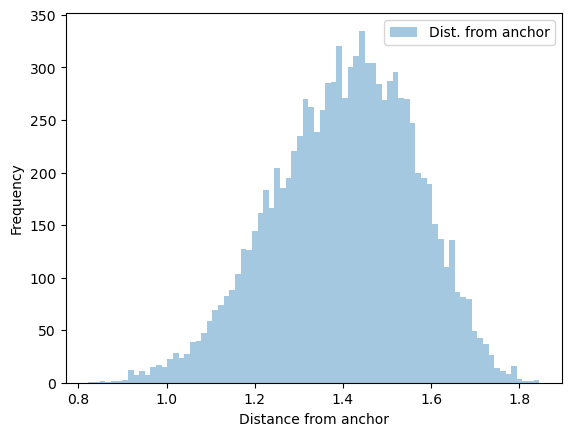

In [127]:
%matplotlib inline
dist1 = np.linalg.norm(z-random_a[0],axis=1)
dist2 = np.linalg.norm(z-random_a[1],axis=1)
dist3 = np.linalg.norm(z-random_a[2],axis=1)
dist4 = np.linalg.norm(z-random_a[3],axis=1)
plt.hist(dist,80,alpha=0.4,label="Dist. from anchor")
# plt.hist(dist1,80,alpha=0.4,label="Dist. from random vec. 1")
# plt.hist(dist2,80,alpha=0.4,label="Dist. from random vec. 2")
# plt.hist(dist3,80,alpha=0.4,label="Dist. from random vec. 3")
#plt.hist(dist4,80,alpha=0.4)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.legend()
plt.show()

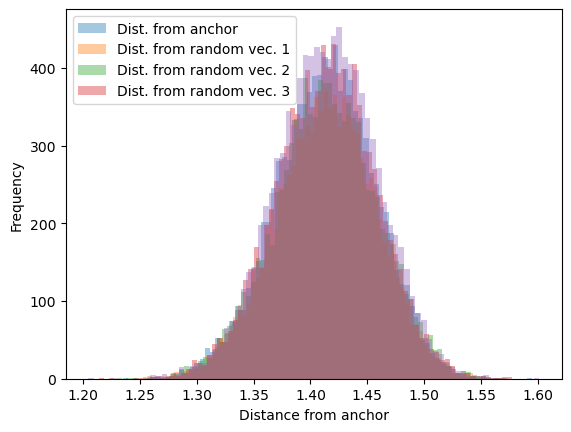

In [230]:
%matplotlib inline
dist1 = np.linalg.norm(z-random_a[0],axis=1)
dist2 = np.linalg.norm(z-random_a[1],axis=1)
dist3 = np.linalg.norm(z-random_a[2],axis=1)
dist4 = np.linalg.norm(z-random_a[3],axis=1)
plt.hist(dist,80,alpha=0.4,label="Dist. from anchor")
plt.hist(dist1,80,alpha=0.4,label="Dist. from random vec. 1")
plt.hist(dist2,80,alpha=0.4,label="Dist. from random vec. 2")
plt.hist(dist3,80,alpha=0.4,label="Dist. from random vec. 3")
plt.hist(dist4,80,alpha=0.4)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [387]:
u = np.linalg.svd(a,full_matrices=True)[2][:,1:].T

In [388]:
random_normals = np.random.uniform(-1,1,(num_of_samples,a.shape[1]-1))
w = random_normals @ u
w = w / np.expand_dims(np.linalg.norm(w,axis=1),-1)

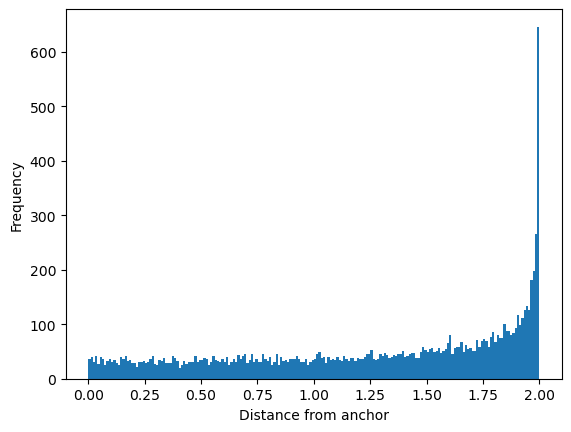

In [389]:
%matplotlib inline
z = np.cos(np.deg2rad(angles)) * a + np.sin(np.deg2rad(angles)) * w
diff = z-a
dist = np.linalg.norm(diff,axis=1)
plt.hist(dist,200)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.show()

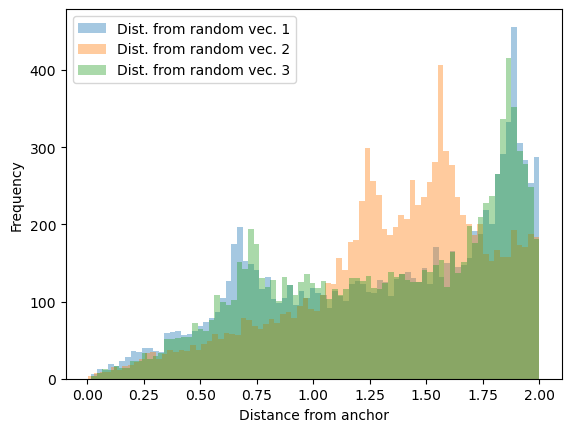

In [390]:
%matplotlib inline
dist1 = np.linalg.norm(z-random_a[0],axis=1)
dist2 = np.linalg.norm(z-random_a[1],axis=1)
dist3 = np.linalg.norm(z-random_a[2],axis=1)
dist4 = np.linalg.norm(z-random_a[3],axis=1)
#plt.hist(dist,80,alpha=0.4,label="Dist. from anchor")
plt.hist(dist1,80,alpha=0.4,label="Dist. from random vec. 1")
plt.hist(dist2,80,alpha=0.4,label="Dist. from random vec. 2")
plt.hist(dist3,80,alpha=0.4,label="Dist. from random vec. 3")
# plt.hist(dist4,80,alpha=0.4)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [393]:
%matplotlib qt
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x1 = np.cos(u)*np.sin(v)
y1 = np.sin(u)*np.sin(v)
z1 = np.cos(v)
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter3D(z[:,0], z[:,1], z[:,2], color='blue', alpha = 0.02, marker=".",label="noise")
ax.scatter3D(a[0][0], a[0][1], a[0][2], color='red',label="anchor")
ax.scatter3D(random_a[:,0], random_a[:,1], random_a[:,2], color='green',marker=">", label="random anchors")
ax.plot_wireframe(x1, y1, z1, color="black", alpha=0.05)
ax.set_title("3D scatterplot", pad=25, size=15)
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")
ax.legend()

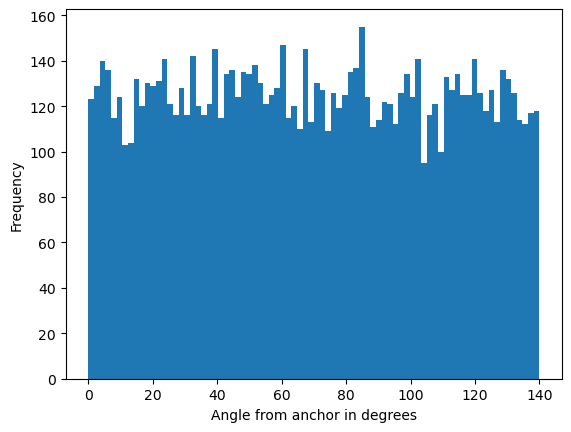

In [211]:
%matplotlib inline
angles_output = []
for i in range(10000):
    z_norm = z[i]/np.linalg.norm(z[i])
    angles_output.append(np.rad2deg(np.arccos(np.dot(a,z_norm))))

angles_output = np.array(angles_output)
plt.hist(angles_output,80)
plt.xlabel("Angle from anchor in degrees")
plt.ylabel("Frequency")
plt.show()

In [28]:
def sample_points_on_sphere(angle, vector, num_points):
    # Normalize the vector with which we want the points to make a certain angle to have unit length
    x = vector / np.linalg.norm(vector)
    x = np.repeat(x,num_points,axis=0)
    # Generate a random vector of the same dimensions as the sphere
    v = np.random.normal(0,1,x.shape)
    # Project v onto the orthogonal complement of the vector x
    y = v - np.einsum('ij,ij->ij',v,x) * x
    # Normalize the resulting vector to have unit length
    y = y / np.linalg.norm(y, axis=0)
    print(x.shape,y.shape)
    # Compute the unit vector perpendicular to both x and y
    z = np.cross(x, y)
    # Generate n uniformly distributed points on a circle of radius sin(θ) in the plane spanned by x and z
    t = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    r = np.sin(angle)
    circle_points = np.stack([r * np.cos(t), r * np.sin(t), np.zeros(num_points)])
    # Compute the corresponding points on the sphere by using Rodrigues' rotation formula
    a = np.cos(angle)
    b = np.sin(angle) * x
    c = np.cross(z, circle_points, axis=0)
    rotated_points = a * circle_points + b + c
    # Add a small random perturbation to each point
    noise = np.random.randn(*vector.shape, num_points)
    return rotated_points + noise

In [33]:
np.deg2rad(90)

1.5707963267948966

## Hopefully

## Correct 

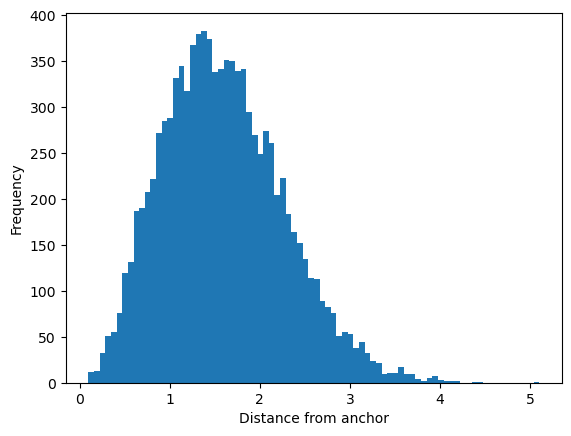

In [3]:
num_of_samples = 10000
dim = 3
dist = 2.0

a = np.random.normal(0,1,(1,dim))
a /= np.linalg.norm(a)

b = np.random.normal(0,1,(num_of_samples,dim))
#b = b / np.expand_dims(np.linalg.norm(b,axis=1),-1)
z = a + b
# norms = np.expand_dims(np.linalg.norm(z,axis=1),-1)
# z /= norms

%matplotlib inline

diff = z-a
dist = np.linalg.norm(diff,axis=1)
plt.hist(dist,80)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.show()

In [4]:
%matplotlib qt
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x1 = np.cos(u)*np.sin(v)
y1 = np.sin(u)*np.sin(v)
z1 = np.cos(v)
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter3D(z[:,0], z[:,1], z[:,2], color='blue', alpha = 0.02, marker=".",label="noise")
ax.scatter3D(a[0][0], a[0][1], a[0][2], color='red',label="anchor")
ax.scatter3D(random_a[:,0], random_a[:,1], random_a[:,2], color='black',marker=">", label="random anchors")
ax.plot_wireframe(x1, y1, z1, color="black", alpha=0.05)
ax.set_title("3D scatterplot", pad=25, size=15)
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")
ax.legend()

NameError: name 'random_a' is not defined

In [94]:
random_a = np.random.normal(0,1,(5,dim))
random_a = random_a / np.expand_dims(np.linalg.norm(random_a,axis=1),-1)

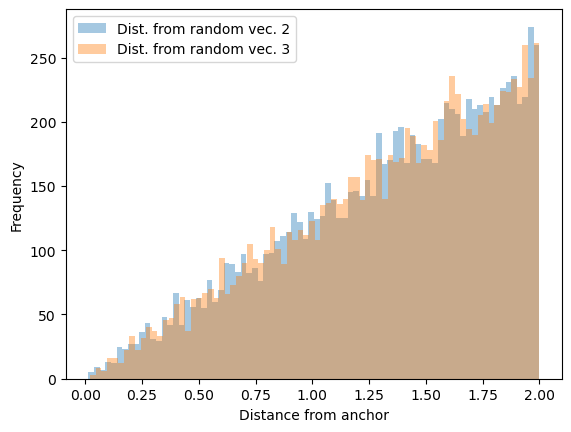

In [95]:
%matplotlib inline
dist1 = np.linalg.norm(z-random_a[0],axis=1)
dist2 = np.linalg.norm(z-random_a[1],axis=1)
dist3 = np.linalg.norm(z-random_a[2],axis=1)
dist4 = np.linalg.norm(z-random_a[3],axis=1)
#plt.hist(dist,80,alpha=0.4,label="Dist. from anchor")
#plt.hist(dist1,80,alpha=0.4,label="Dist. from random vec. 1")
plt.hist(dist2,80,alpha=0.4,label="Dist. from random vec. 2")
plt.hist(dist3,80,alpha=0.4,label="Dist. from random vec. 3")
# plt.hist(dist4,80,alpha=0.4)
plt.xlabel("Distance from anchor")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [30]:
%matplotlib qt
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x1 = np.cos(u)*np.sin(v)
y1 = np.sin(u)*np.sin(v)
z1 = np.cos(v)
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter3D(z[:,0], z[:,1], z[:,2], color='blue', alpha = 0.02, marker=".",label="noise")
ax.scatter3D(a[0][0], a[0][1], a[0][2], color='red',label="anchor")
# ax.scatter3D(random_a[:,0], random_a[:,1], random_a[:,2], color='green',marker=">", label="random anchors")
ax.plot_wireframe(x1, y1, z1, color="black", alpha=0.05)
ax.set_title("3D scatterplot", pad=25, size=15)
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")
ax.legend()

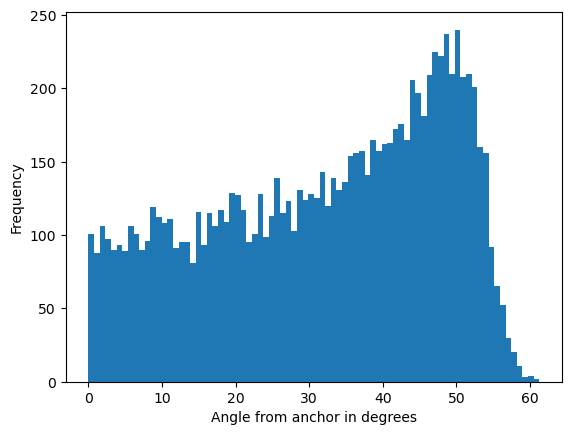

In [26]:
angles_output = []
for i in range(10000):
    z_norm = z[i]/np.linalg.norm(z[i])
    angles_output.append(np.rad2deg(np.arccos(np.dot(a,z_norm))))

angles_output = np.array(angles_output)
plt.hist(angles_output,80)
plt.xlabel("Angle from anchor in degrees")
plt.ylabel("Frequency")
plt.show()

In [19]:
dede = np.rad2deg(generate_angle(100000))

In [153]:
cum = []
y = 0
x = []
for i in np.arange(0, 180.0, 0.01):
    y += np.sin(np.deg2rad(i))/2
    x.append(np.deg2rad(i))
    cum.append(y)

cum /= y
curve = np.polyfit(x, cum, 5)

In [154]:
curve = np.polyfit(x, cum, 5)
new_y = np.polyval(curve,x)

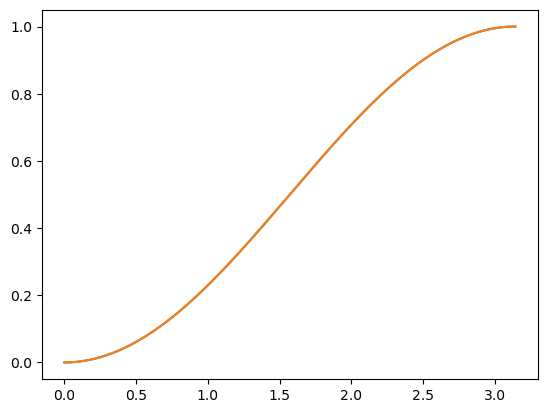

In [157]:
%matplotlib inline
plt.plot(x,cum)
plt.plot(x,new_y)

In [201]:
import lpips
loss_fn_vgg = lpips.LPIPS(net='vgg')

img0 = torch.normal(0,1,(1,3,32,32)) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = torch.normal(0,1,(1,3,32,32))
loss_fn_vgg(img0, img1, retPerLayer=True)


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/cva19/anaconda3/envs/pypi/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


(tensor([[[[0.2650]]]], grad_fn=<AddBackward0>),
 [tensor([[[[0.1047]]]], grad_fn=<MeanBackward1>),
  tensor([[[[0.0812]]]], grad_fn=<MeanBackward1>),
  tensor([[[[0.0445]]]], grad_fn=<MeanBackward1>),
  tensor([[[[0.0204]]]], grad_fn=<MeanBackward1>),
  tensor([[[[0.0142]]]], grad_fn=<MeanBackward1>)])

In [214]:
from torchvision.models import vgg16_bn, vgg16

model = vgg16(pretrained=True)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [217]:
a = torch.zeros(1,3,256,256)
torch.argmax(model(a))

tensor(623)

In [43]:
w = np.random.normal(0,1,(1000,3))
w_mean = np.mean(w,axis=0)
phi = 1

In [41]:
w_new = w_mean + phi * (w - w_mean)

In [44]:
%matplotlib qt


u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x1 = np.cos(u)*np.sin(v)
y1 = np.sin(u)*np.sin(v)
z1 = np.cos(v)
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter3D(w[:,0], w[:,1], w[:,2], color='blue', alpha = 0.2, marker=".",label="noise")
#ax.scatter3D(random_a[:,0], random_a[:,1], random_a[:,2], color='black',marker=">", label="random anchors")
ax.plot_wireframe(x1, y1, z1, color="black", alpha=0.05)
ax.set_title("3D scatterplot", pad=25, size=15)
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")
ax.legend()

In [42]:
%matplotlib qt


u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
x1 = np.cos(u)*np.sin(v)
y1 = np.sin(u)*np.sin(v)
z1 = np.cos(v)
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter3D(w_new[:,0], w_new[:,1], w_new[:,2], color='blue', alpha = 0.2, marker=".",label="noise")
#ax.scatter3D(random_a[:,0], random_a[:,1], random_a[:,2], color='black',marker=">", label="random anchors")
ax.plot_wireframe(x1, y1, z1, color="black", alpha=0.05)
ax.set_title("3D scatterplot", pad=25, size=15)
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.set_zlabel("Z")
ax.legend()